In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [ ]:
sub1= pd.read_csv('sub_71930.csv')
sub2= pd.read_csv('sub_71947.csv')
sub3= pd.read_csv('sub_71965.csv')
sub4= pd.read_csv('sub_72376.csv')
sub5= pd.read_csv('sub_72383.csv')
sub6= pd.read_csv('sub_72384.csv')


In [ ]:
import numpy as np

# 각 모델의 RMSE 값
rmses = np.array([71930, 71947, 71965, 72376, 72383, 72384])

# RMSE의 역수 계산
inverse_rmses = 1 / rmses

# 가중치 계산
weights = inverse_rmses / np.sum(inverse_rmses)

# 가중치 출력
print(weights)

In [13]:
train = pd.read_csv('train33.csv')
test = pd.read_csv('test33.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
# 브랜드별 평균 가격 계산
brand_avg_price = train.groupby('brand')['price'].mean()

# 평균 가격을 기준으로 정렬
sorted_brands = brand_avg_price.sort_values(ascending=False)

# 브랜드를 매핑할 딕셔너리 생성
brand_mapping = {brand: index for index, brand in enumerate(sorted_brands.index)}

# 원래 데이터프레임에 라벨 인코딩 적용
train['brand_encoded'] = train['brand'].map(brand_mapping)
train = train.drop(columns=['brand'])
test['brand_encoded'] = test['brand'].map(brand_mapping)

test = test.drop(columns=['brand'])



In [4]:


# 범주형 열과 숫자형 열을 구분
categorical_columns = ['main_int_color','main_ext_color', 'model', 'fuel_type', 'transmission_type', 'special_feature']
numerical_columns = [col for col in train.columns if col not in categorical_columns and col not in ['price', 'log_price']]  # price와 log_price 제외

# train과 test 데이터를 합침
combined_data = pd.concat([train[categorical_columns], test[categorical_columns]], axis=0)

# 원핫 인코딩할 열과 라벨 인코딩할 열 구분
onehot_columns = ['transmission_type', 'special_feature']
label_columns = ['main_int_color','main_ext_color','model', 'fuel_type']

# 원핫 인코딩
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse_output 사용
onehot_encoded = onehot_encoder.fit_transform(combined_data[onehot_columns])

# 라벨 인코딩
label_encoders = {}
for col in label_columns:
    label_encoders[col] = LabelEncoder()
    combined_data[col] = label_encoders[col].fit_transform(combined_data[col])

# train, test 데이터를 나눔
train_encoded = combined_data.iloc[:len(train)]
test_encoded = combined_data.iloc[len(train):]

# 원핫 인코딩한 값을 DataFrame으로 변환해서 합치기
onehot_encoded_train = pd.DataFrame(onehot_encoded[:len(train)], columns=onehot_encoder.get_feature_names_out(onehot_columns))
onehot_encoded_test = pd.DataFrame(onehot_encoded[len(train):], columns=onehot_encoder.get_feature_names_out(onehot_columns))

# 최종적으로 인코딩된 train, test 데이터에 원핫 인코딩된 열 추가
train_encoded = pd.concat([train_encoded.reset_index(drop=True), onehot_encoded_train.reset_index(drop=True)], axis=1)
test_encoded = pd.concat([test_encoded.reset_index(drop=True), onehot_encoded_test.reset_index(drop=True)], axis=1)

# 불필요한 원핫 인코딩 전의 열 제거
train_encoded.drop(onehot_columns, axis=1, inplace=True)
test_encoded.drop(onehot_columns, axis=1, inplace=True)

# 숫자형 변수들을 기존의 인코딩된 train, test 데이터에 병합
train_final = pd.concat([train_encoded.reset_index(drop=True), train[numerical_columns].reset_index(drop=True), train[['price', 'log_price']].reset_index(drop=True)], axis=1)
test_final = pd.concat([test_encoded.reset_index(drop=True), test[numerical_columns].reset_index(drop=True)], axis=1)


# 먼저 train_final과 test_final을 합칩니다
combined = pd.concat([train_final[['accident', 'horsepower', 'displacement', 'cylinder_count']],
                      test_final[['accident', 'horsepower', 'displacement', 'cylinder_count']]])

# 합친 데이터에서 최빈값을 구한 뒤 결측값을 채웁니다
for column in ['accident', 'horsepower', 'displacement', 'cylinder_count']:
    mode_value = combined[column].mode()[0]  # 합친 데이터에서 최빈값 계산
    test_final[column].fillna(mode_value, inplace=True)  # test_final의 결측값을 최빈값으로 채우기


C:\Users\mm\AppData\Local\Temp\ipykernel_15328\2059670038.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_final[column].fillna(mode_value, inplace=True)  # test_final의 결측값을 최빈값으로 채우기


<Axes: >

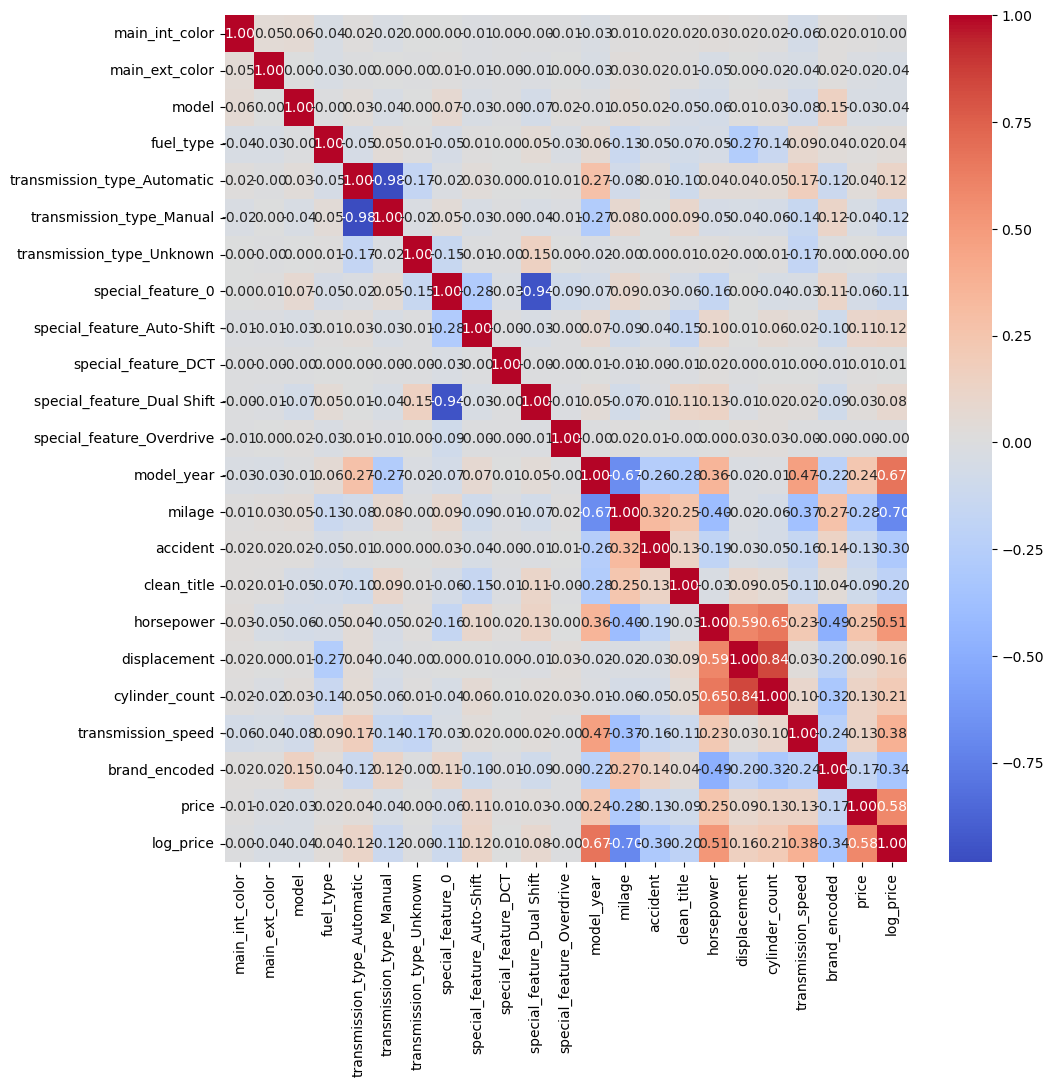

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,11))

corr_matrix = train_final.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')


In [1]:
!pip install autogluon

  Using cached autogluon-1.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached autogluon.core-1.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached autogluon.features-1.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached autogluon.tabular-1.1.1-py3-none-any.whl.metadata (13 kB)
  Using cached autogluon.multimodal-1.1.1-py3-none-any.whl.metadata (12 kB)
  Using cached autogluon.timeseries-1.1.1-py3-none-any.whl.metadata (12 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
  Using cached boto3-1.35.28-py3-none-any.whl.metadata (6.6 kB)
  Using cached autogluon.common-1.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached lightning-2.3.3-py3-none-any.whl.metadata (35 kB)
  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached accelerate-0.21.0-py3-none-any.whl.metadata (17 kB)
  Using

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires libclang>=13.0.0, which is not installed.
tensorflow 2.10.0 requires tensorflow-io-gcs-filesystem>=0.23.1, which is not installed.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 5.27.1 which is incompatible.
tensorflow 2.10.0 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.18.0 which is incompatible.


In [5]:
from autogluon.tabular import TabularPredictor

# train_final과 test_final을 준비
train_data = train_final.copy()
test_data = test_final.copy()

# 타겟 변수는 'log_price'로 설정
label_column = 'price'


c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:

# train_final과 test_final을 준비
train_data = train_final.copy()
test_data = test_final.copy()

# 타겟 변수는 'log_price'로 설정
label_column = 'price'


In [ ]:
# 모델 학습 (AutoGluon으로 log_price 예측)
predictor = TabularPredictor(label=label_column, eval_metric='rmse').fit(
    train_data=train_data.drop(columns=['log_price']),
    presets='best_quality',  # 성능 우선 학습
    time_limit=3600,  # 최대 학습 시간 1시간 설정 (필요에 따라 조절 가능)
    num_bag_folds=5
)

In [22]:
# 모델 학습 (AutoGluon으로 log_price 예측)
predictor = TabularPredictor(label=label_column, eval_metric='rmse').fit(
    train_data=train_data.drop(columns=['log_price']),
    presets='best_quality',  # 성능 우선 학습
    feature_prune_kwargs={'enable': True}, 
    time_limit=3600
)

No path specified. Models will be saved in: "AutogluonModels\ag-20240929_152823"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       1.98 GB / 7.94 GB (25.0%)
Disk Space Avail:   372.25 GB / 1863.00 GB (20.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [21]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub6_4.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         18819.980469
1         77568.445312
2         57626.679688
3         25725.984375
4         30232.373047
              ...     
125685    25316.251953
125686    46268.570312
125687    22712.875000
125688    15856.151367
125689    35622.554688
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                     model     score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -72323.238353  root_mean_squared_error      24.292053  619.455996                0.003999           0.828001            3       True         20
1          CatBoost_BAG_L2 -72349.346425  root_mean_squared_error      17.335059  558.263995                0.061013          29.308000            2       True         17
2      WeightedEnsemble_L2 -72429.844060  root_mean_squared_error      11.820026  469.300996                0.005001           0

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_

2024-09-30 00:12:45,730	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-30 00:12:47,142	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-30 00:12:47,598	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-30 00:12:47,657	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


In [23]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub6_5.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         18672.646484
1         79325.703125
2         56561.742188
3         25852.044922
4         30387.306641
              ...     
125685    25099.251953
125686    46289.328125
125687    22664.175781
125688    15868.023438
125689    36678.734375
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                          model     score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3 -72291.556819  root_mean_squared_error      70.898434  2066.631061                0.002997           1.254999            3       True         27
1               CatBoost_BAG_L2 -72334.735384  root_mean_squared_error      60.961428  1722.077068                0.064992          28.228000            2       True         22
2        NeuralNetFastAI_BAG_L2 -72369.607542  root_mean_squared_error      64.075444  1963.790067            

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel

In [16]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub6_3.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         18236.546875
1         75100.914062
2         55948.855469
3         26362.582031
4         30612.226562
              ...     
125685    26115.070312
125686    54681.683594
125687    22675.498047
125688    16251.326172
125689    39625.800781
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                        model     score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3 -72264.020209  root_mean_squared_error      47.099921  2577.908446                0.002999           0.932000            3       True         23
1             CatBoost_BAG_L2 -72311.649477  root_mean_squared_error      28.047935  2090.336434                0.254940         359.066142            2       True         19
2         WeightedEnsemble_L2 -72322.615505  root_mean_squared_error      18.539003  1128.232223                0.00

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2'

In [7]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub6_1.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         17955.064453
1         77912.382812
2         58421.324219
3         25880.369141
4         30270.664062
              ...     
125685    25467.191406
125686    46904.074219
125687    22688.986328
125688    15647.858398
125689    36555.265625
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                          model     score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3 -72335.437627  root_mean_squared_error      51.377027  2151.284971                0.004000           1.140998            3       True         31
1        NeuralNetFastAI_BAG_L2 -72394.537286  root_mean_squared_error      43.115020  1953.193982                2.350995         234.454997            2       True         26
2               CatBoost_BAG_L2 -72395.339963  root_mean_squared_error      40.808023  1732.272981            

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel

In [8]:
# 모델 학습 (AutoGluon으로 log_price 예측)
predictor = TabularPredictor(label=label_column, eval_metric='rmse').fit(
    train_data=train_data.drop(columns=['log_price']),
    presets='best_quality',  # 성능 우선 학습
    time_limit=3600,  # 최대 학습 시간 1시간 설정 (필요에 따라 조절 가능)
)

No path specified. Models will be saved in: "AutogluonModels\ag-20240929_093451"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       1.76 GB / 7.94 GB (22.2%)
Disk Space Avail:   378.44 GB / 1863.00 GB (20.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [9]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub6_2.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         18474.384766
1         80016.500000
2         56616.867188
3         25640.812500
4         30290.824219
              ...     
125685    24650.451172
125686    46444.640625
125687    22402.646484
125688    15370.639648
125689    36420.312500
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                          model     score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3 -72282.758522  root_mean_squared_error      66.013184  2071.514539                0.005001           1.115001            3       True         28
1               CatBoost_BAG_L2 -72328.328283  root_mean_squared_error      54.211196  1739.170537                0.069083          29.327998            2       True         22
2        NeuralNetFastAI_BAG_L2 -72349.955137  root_mean_squared_error      57.007111  1945.748540            

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel

In [44]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub5_5.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         17609.648438
1         76662.312500
2         57782.382812
3         24593.390625
4         30677.769531
              ...     
125685    27347.640625
125686    46705.496094
125687    24076.689453
125688    15807.047852
125689    36984.636719
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                  model     score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -72453.133629  root_mean_squared_error       3.442533  83.508522                0.004000           0.426001            2       True          7
1   WeightedEnsemble_L3 -72453.133629  root_mean_squared_error       3.443536  83.523524                0.005002           0.441002            3       True          8
2       CatBoost_BAG_L1 -72513.331816  root_mean_squared_error       0.440007  36.174998                0.440007          36.174998         

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': -73584.18899748141,
  'LightGBM_BAG_L1': -72546.63650078692,
  'CatBoost_BAG_L1': -72513.33181630433,
  'LightGBMLarge_BAG_L1': -74076.1976102961,
  'CatBoost_r177_BAG_L1': -72519.72102022795,
  'LightGBM_r131_BAG_L1': -73442.02521807613,
  'WeightedEnsemble_L2': -72453.13362932783,
  'WeightedEnsemble_L3': -72453.13362932783},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT_BAG_L1': ['LightGBMXT_BAG_L1'],
  'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'CatBoost_BAG_L1': ['CatBoost_BAG_L1'],
  'Lig

In [33]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)
print(y_pred)

sub.price = y_pred
sub.to_csv('sub5_3.csv', index=False)

# 모델 성능 요약
predictor.fit_summary()

0         18139.615234
1         76226.937500
2         59249.882812
3         26796.039062
4         30360.398438
              ...     
125685    24907.488281
125686    45703.230469
125687    22489.976562
125688    15751.041016
125689    36574.695312
Name: price, Length: 125690, dtype: float32
*** Summary of fit() ***
Estimated performance of each model:
                     model     score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -72289.830263  root_mean_squared_error      21.527025  359.041020                0.003998           0.614999            3       True         17
1          CatBoost_BAG_L2 -72321.257787  root_mean_squared_error      18.189029  280.495024                0.059023          26.103999            2       True         15
2        LightGBMXT_BAG_L2 -72380.490604  root_mean_squared_error      18.987005  262.589023                0.856999           8

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -79261.74

In [13]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)

In [14]:
y_pred

0         17988.269531
1         78752.296875
2         58744.617188
3         26561.724609
4         30456.355469
              ...     
125685    25197.871094
125686    45864.703125
125687    22670.650391
125688    16039.620117
125689    36311.320312
Name: price, Length: 125690, dtype: float32

In [15]:

# 모델 성능 요약
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model     score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -72333.046302  root_mean_squared_error      17.353028  306.736297                0.003001           0.703000            3       True         17
1          CatBoost_BAG_L2 -72349.896255  root_mean_squared_error      15.834016  291.269297                0.061025          37.856998            2       True         15
2        LightGBMXT_BAG_L2 -72397.715436  root_mean_squared_error      16.715998  261.885298                0.943007           8.473000            2       True         12
3      WeightedEnsemble_L2 -72436.798144  root_mean_squared_error       7.230013   63.136299                0.006002           1.135999            2       True         11
4          LightGBM_BAG_L2 -72493.918676  root_mean_squared_error      16.345996  2

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -79382.52

In [16]:

sub.price = y_pred

In [18]:
sub.to_csv('sub5_2.csv', index=False)

In [5]:
from autogluon.tabular import TabularPredictor

# train_final과 test_final을 준비
train_data = train_final.copy()
test_data = test_final.copy()

# 타겟 변수는 'log_price'로 설정
label_column = 'log_price'



c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 모델 학습 (AutoGluon으로 log_price 예측)
predictor = TabularPredictor(label=label_column, eval_metric='rmse').fit(
    train_data=train_data.drop(columns=['price']),
    presets='best_quality',  # 성능 우선 학습
    time_limit=3600  # 최대 학습 시간 1시간 설정 (필요에 따라 조절 가능)
)

No path specified. Models will be saved in: "AutogluonModels\ag-20240928_152233"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       1.85 GB / 7.94 GB (23.3%)
Disk Space Avail:   385.27 GB / 1863.00 GB (20.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

(_ray_fit pid=22440) [1000]	valid_set's rmse: 0.491889
(_ray_fit pid=23172) [2000]	valid_set's rmse: 0.49692 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(_dystack pid=17540) 	-0.4915	 = Validation score   (-root_mean_squared_error)
(_dystack pid=17540) 	30.36s	 = Training   runtime
(_dystack pid=17540) 	13.98s	 = Validation runtime
(_dystack pid=17540) Fitting model: LightGBM_BAG_L1 ... Training model for up to 552.57s of the 850.64s of remaining time.
(_dystack pid=17540) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=3.96%)


(_ray_fit pid=1488) [1000]	valid_set's rmse: 0.489626
(_ray_fit pid=1440) [1000]	valid_set's rmse: 0.48797


(_dystack pid=17540) 	-0.4895	 = Validation score   (-root_mean_squared_error)
(_dystack pid=17540) 	17.78s	 = Training   runtime
(_dystack pid=17540) 	7.72s	 = Validation runtime
(_dystack pid=17540) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 528.25s of the 826.32s of remaining time.
(_dystack pid=17540) 	Warning: Reducing model 'n_estimators' from 300 -> 185 due to low memory. Expected memory usage reduced from 24.23% -> 15.0% of available memory...
(_dystack pid=17540) 	-0.5036	 = Validation score   (-root_mean_squared_error)
(_dystack pid=17540) 	27.87s	 = Training   runtime
(_dystack pid=17540) 	3.79s	 = Validation runtime
(_dystack pid=17540) Fitting model: CatBoost_BAG_L1 ... Training model for up to 494.51s of the 792.58s of remaining time.
(_dystack pid=17540) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=4.10%)
(_dystack pid=17540) 	-0.489	 = Validation score   (-root_mean_

In [7]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)

# 예측 결과는 log_price이므로 다시 exp()를 사용하여 역변환
test_data['predicted_price'] = np.exp(y_pred)

In [8]:

# 모델 성능 요약
predictor.fit_summary()

# 성능 평가
performance = predictor.evaluate(train_data)
print(f"Train RMSE: {performance['rmse']}")

*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L3  -0.485323  root_mean_squared_error     105.810998  2489.201774                0.006001           1.038999            3       True         24
1             CatBoost_BAG_L2  -0.485960  root_mean_squared_error      87.016002  1776.581778                0.074007          64.965001            2       True         19
2      NeuralNetFastAI_BAG_L2  -0.485994  root_mean_squared_error      89.551991  1917.849774                2.609996         206.232997            2       True         21
3         WeightedEnsemble_L2  -0.485997  root_mean_squared_error      37.448989   808.002208                0.003997           0.813995            2       True         15
4             LightGBM_BAG_L2  -0.486025  root_mean_squared_error      88.0389

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


KeyError: 'rmse'

In [17]:

# 모델 성능 요약
predictor.fit_summary()

# 성능 평가
performance = predictor.evaluate(train_data)
print(f"Train RMSE: {performance['rmse']}")

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.486154  root_mean_squared_error      51.908982  369.509157                0.004001           0.717998            3       True         13
1          CatBoost_BAG_L2  -0.486496  root_mean_squared_error      47.028964  292.352163                0.074980          43.386998            2       True         12
2          LightGBM_BAG_L2  -0.486537  root_mean_squared_error      47.984003  259.619164                1.030019          10.654000            2       True         10
3      WeightedEnsemble_L2  -0.486649  root_mean_squared_error      46.541983  246.511162                0.003000           0.939000            2       True          8
4        LightGBMXT_BAG_L2  -0.487079  root_mean_squared_error      49.012982  263.294164         

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


KeyError: 'rmse'

In [9]:
test_data['predicted_price']

0         16291.962891
1         62974.109375
2         52063.378906
3         23294.488281
4         28923.935547
              ...     
125685    22042.332031
125686    42419.886719
125687    19360.583984
125688    13282.612305
125689    34811.886719
Name: predicted_price, Length: 125690, dtype: float32

In [19]:
test_data['predicted_price']

0         16192.087891
1         62961.082031
2         52032.253906
3         23039.880859
4         29423.804688
              ...     
125685    21911.128906
125686    43279.902344
125687    19758.035156
125688    13629.318359
125689    34631.152344
Name: predicted_price, Length: 125690, dtype: float32

In [10]:
sub.price = test_data['predicted_price']
sub.to_csv('sub5_1.csv', index=False)

In [24]:
predictor = TabularPredictor(label=label_column, eval_metric='rmse').fit(
    train_data=train_data.drop(columns=['price']),
    presets='best_quality',  # 'best_quality'는 성능을 우선시, 'optimize_for_deployment'는 빠른 속도
    time_limit=600,  # 학습 시간 제한
    hyperparameters={
        'GBM': {},    # LightGBM 사용
        'CAT': {},    # CatBoost 사용
        'XGB': {},    # XGBoost 사용
        'NN_TORCH': {} # 신경망 모델 사용
    }
)

No path specified. Models will be saved in: "AutogluonModels\ag-20240927_180650"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Memory Avail:       3.33 GB / 7.94 GB (42.0%)
Disk Space Avail:   385.49 GB / 1863.00 GB (20.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [25]:
# 테스트 데이터 예측
y_pred = predictor.predict(test_data)

# 예측 결과는 log_price이므로 다시 exp()를 사용하여 역변환
test_data['predicted_price'] = np.exp(y_pred)

# 모델 성능 요약
predictor.fit_summary()

# 성능 평가
performance = predictor.evaluate(train_data)
print(f"Train RMSE: {performance['rmse']}")

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L3  -0.487595  root_mean_squared_error      16.747029  320.321988                0.010001           1.211999            3       True          9
1    WeightedEnsemble_L2  -0.487647  root_mean_squared_error      14.894020  273.910998                0.007007           0.434000            2       True          4
2        CatBoost_BAG_L2  -0.487946  root_mean_squared_error      14.973008  297.999994                0.085996          24.522996            2       True          6
3        LightGBM_BAG_L2  -0.488156  root_mean_squared_error      15.854025  282.582995                0.967013           9.105997            2       True          5
4         XGBoost_BAG_L2  -0.488367  root_mean_squared_error      15.684019  285.480996                0.797

c:\Users\mm\anaconda3\envs\ogc2024\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


KeyError: 'rmse'

In [26]:
sub.price = test_data['predicted_price']
sub.to_csv('sub4_2.csv', index=False)

In [23]:
test_data['predicted_price']

0         16192.087891
1         62961.082031
2         52032.253906
3         23039.880859
4         29423.804688
              ...     
125685    21911.128906
125686    43279.902344
125687    19758.035156
125688    13629.318359
125689    34631.152344
Name: predicted_price, Length: 125690, dtype: float32

In [27]:
test_data['predicted_price']

0         15813.573242
1         60029.082031
2         53069.429688
3         22864.574219
4         29550.070312
              ...     
125685    22911.699219
125686    42574.750000
125687    19772.679688
125688    13094.643555
125689    35944.449219
Name: predicted_price, Length: 125690, dtype: float32

In [ ]:
from autogluon.tabular import TabularPredictor

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')
Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool

from xgboost import XGBRegressor


import random

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from autogluon.tabular import TabularPredictor



train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')
Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))


train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)


train = pd.concat([train, Original], ignore_index=True)






def extract_age_features(df):
    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
    
    return df


def extract_other_features(df):
    
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    



    return df

train = extract_age_features(train)
test = extract_age_features(test)

train = extract_other_features(train)
test = extract_other_features(test)





def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title',
             
            ]
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

train  = update(train)
test   = update(test)

X = train.drop('price', axis=1)
y = train['price']

In [ ]:
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold



callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"cat_cols--------{cat_cols}")


def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

    
    oof_predictions = np.zeros(len(df))
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    models = []
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold + 1}/{5} with {model_type}")

        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        if model_type == 'LGBM':
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'valid'],
                callbacks=callbacks    
            )
        
        elif model_type == 'CAT':
            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
            model = CatBoostRegressor(**cat_params)
            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
        models.append(model)
        
        if model_type == 'LGBM':
            pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'CAT':
            pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

        print(f'{model_type} Fold RMSE: {rmse}')
        
        oof_predictions[val_idx] = pred
        
    print(f'Mean RMSE: {np.mean(rmse_scores)}')
    return oof_predictions, models




lgb_params = {
    'objective': 'MAE',
    'n_estimators': 1000,
    'random_state': 1,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
X['LGBM_MAE'] = oof_predictions_lgbm


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MAE'] = LGBM_preds



lgb_params = {
    'objective': 'MSE',
    'n_estimators': 1000,
    'random_state': 1,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MSE_diff'] = LGBM_preds - test['LGBM_MAE']

test.head()

In [ ]:
X['price'] = y

predictor = TabularPredictor(label='price',
                            eval_metric='rmse',
                            problem_type='regression').fit(X,
                                                       presets='best_quality',
                                                       time_limit=3600*1,
                                                       verbosity=2,
                                                       num_gpus=0,
                                                       included_model_types=['GBM', 'CAT']
                                                      )



y_pred = predictor.predict(test)

# A bit of blending with the solution already blended from kagglers. Can be tweaked (currently 50/50).
sub_blend = pd.read_csv('/kaggle/input/top-5-blended-car-prices/submission_9.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
sample_sub['price'] =  y_pred * 0.5 + sub_blend['price'] * 0.5
sample_sub.to_csv("submission.csv", index=False)
sample_sub.head()

In [57]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# train 데이터에서 특성과 타겟 변수 분리
X = train_final.drop(columns=['price', 'log_price'])  # 특성 (price와 log_price 제외)
y = train['log_price']  # 타겟 변수 (log_price)

# 데이터 분할 (훈련/검증)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_final)

# PyTorch 데이터셋 클래스 정의
class CarPriceDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.FloatTensor(self.features[index]), torch.FloatTensor([self.targets[index]])

# 데이터 로더 설정
train_dataset = CarPriceDataset(X_train, y_train.values)
val_dataset = CarPriceDataset(X_val, y_val.values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 모델, 손실 함수 및 옵티마이저 설정
model = NeuralNetwork(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features).squeeze()
        loss = criterion(outputs, batch_targets.squeeze())
        loss.backward()
        optimizer.step()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_features, val_targets in val_loader:
            val_outputs = model(val_features).squeeze()
            val_loss += criterion(val_outputs, val_targets.squeeze()).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

# 테스트 데이터 예측
model.eval()
with torch.no_grad():
    test_predictions = model(torch.FloatTensor(X_test)).squeeze().numpy()

# 로그 변환된 가격을 역변환
test_predictions_exp = np.exp(test_predictions)

predict = pd.DataFrame({'predicted_price': test_predictions_exp})

# 예측 결과 출력

sub.price = predict.predicted_price
sub.to_csv('sub3_2.csv', index=False)

Epoch [1/100], Validation Loss: 0.2714
Epoch [2/100], Validation Loss: 0.2657
Epoch [3/100], Validation Loss: 0.2641
Epoch [4/100], Validation Loss: 0.2714
Epoch [5/100], Validation Loss: 0.2784
Epoch [6/100], Validation Loss: 0.2650
Epoch [7/100], Validation Loss: 0.2613
Epoch [8/100], Validation Loss: 0.2676
Epoch [9/100], Validation Loss: 0.2565
Epoch [10/100], Validation Loss: 0.2669
Epoch [11/100], Validation Loss: 0.2572
Epoch [12/100], Validation Loss: 0.2615
Epoch [13/100], Validation Loss: 0.2534
Epoch [14/100], Validation Loss: 0.2597
Epoch [15/100], Validation Loss: 0.2548
Epoch [16/100], Validation Loss: 0.2588
Epoch [17/100], Validation Loss: 0.2620
Epoch [18/100], Validation Loss: 0.2581
Epoch [19/100], Validation Loss: 0.2783
Epoch [20/100], Validation Loss: 0.2558
Epoch [21/100], Validation Loss: 0.2780
Epoch [22/100], Validation Loss: 0.2558
Epoch [23/100], Validation Loss: 0.2566
Epoch [24/100], Validation Loss: 0.2569
Epoch [25/100], Validation Loss: 0.2562
Epoch [26

In [63]:
sub[sub['price'].isnull()]['id']

13811    202344
43300    231833
84697    273230
Name: id, dtype: int64

In [74]:
sub.loc[sub['id'] == 202344, 'price'] = sub2.loc[sub2['id'] == 202344, 'price'].values[0]
sub.loc[sub['id'] == 231833, 'price'] = sub2.loc[sub2['id'] == 231833, 'price'].values[0]
sub.loc[sub['id'] == 273230, 'price'] = sub2.loc[sub2['id'] == 273230, 'price'].values[0]


In [72]:
sub['price'].isnull().sum()

0

In [75]:

sub.to_csv('sub3_2.csv', index=False)

In [67]:
sub2 = sub.copy()
sub2.price = predicted_prices_df_lgb.predicted_price_lgb


In [61]:
sub.isnull().sum()

id       0
price    3
dtype: int64

In [59]:
test

,model,model_year,milage,fuel_type,accident,clean_title,horsepower,displacement,cylinder_count,transmission_type,transmission_speed,special_feature,main_int_color,main_ext_color,brand_encoded
0,Rover LR2 Base,2015,98000,Gasoline,0.0,1,240.0,2.0,4.0,Automatic,6,0,Beige,White,11.0
1,Rover Defender SE,2020,9142,Hybrid,0.0,1,395.0,3.0,6.0,Automatic,8,0,Black,Silver,11.0
2,Expedition Limited,2022,28121,Gasoline,0.0,0,375.0,3.5,6.0,Automatic,10,0,Brown,White,22.0
3,A6 2.0T Sport,2016,61258,Gasoline,0.0,0,252.0,2.0,4.0,Automatic,7,0,Black,Yellow,21.0
4,A6 2.0T Premium Plus,2018,59000,Gasoline,0.0,1,252.0,2.0,4.0,Automatic,8,0,Black,Gray,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,GL-Class GL 450 4MATIC,2014,83315,Gasoline,0.0,1,362.0,3.0,6.0,Automatic,7,0,Black,Black,14.0
125686,Q7 55 Prestige,2019,29336,Gasoline,0.0,0,329.0,3.0,6.0,Automatic,8,0,Black,White,21.0
125687,A6 3.0T Premium Plus,2012,77634,Gasoline,0.0,1,333.0,3.0,6.0,Automatic,7,0,Black,Black,21.0
125688,Q7 3.0T Premium,2012,112000,Gasoline,0.0,1,333.0,3.0,6.0,Automatic,0,0,Black,Black,21.0


In [54]:
test_predictions_exp

array([15812.699 , 67745.625 , 53826.406 , ..., 19030.22  , 13860.6875,
       35965.19  ], dtype=float32)

In [46]:
train_final

,model,fuel_type,transmission_type_Automatic,transmission_type_Manual,transmission_type_Unknown,special_feature_0,special_feature_Auto-Shift,special_feature_DCT,special_feature_Dual Shift,special_feature_Overdrive,...,milage,accident,clean_title,horsepower,displacement,cylinder_count,transmission_speed,brand_encoded,price,log_price
0,495,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,213000,0,1,172.0,1.6,4.0,6,53,4200.0,8.343078
1,930,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,143250,1,1,252.0,3.9,8.0,5,33,4999.0,8.517193
2,1575,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,136731,0,1,320.0,5.3,8.0,0,19,13900.0,9.539716
3,758,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,19500,0,1,420.0,5.0,8.0,8,12,45000.0,10.714440
4,1077,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7388,0,1,208.0,2.0,4.0,7,14,97500.0,11.487618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182486,604,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,49000,0,1,420.0,6.2,8.0,8,17,27500.0,10.221978
182487,206,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,28600,1,1,385.0,3.0,6.0,8,14,30000.0,10.308986
182488,223,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13650,0,1,469.0,4.0,8.0,7,14,86900.0,11.372525
182489,1471,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13895,0,0,333.0,3.0,6.0,1,21,84900.0,11.349241


In [35]:
test_final.isnull().sum()

model                          0
fuel_type                      0
main_int_color                 0
main_ext_color                 0
transmission_type_Automatic    0
transmission_type_Manual       0
transmission_type_Unknown      0
special_feature_0              0
special_feature_Auto-Shift     0
special_feature_DCT            0
special_feature_Dual Shift     0
special_feature_Overdrive      0
model_year                     0
milage                         0
accident                       0
clean_title                    0
horsepower                     0
displacement                   0
cylinder_count                 0
transmission_speed             0
brand_encoded                  3
dtype: int64

In [8]:
train

,model,model_year,milage,fuel_type,accident,clean_title,price,horsepower,displacement,cylinder_count,log_price,transmission_type,transmission_speed,special_feature,main_int_color,main_ext_color,brand_encoded
0,Cooper S Base,2007,213000,Gasoline,0,1,4200.0,172.0,1.6,4.0,8.343078,Automatic,6,0,Gray,Yellow,53
1,LS V8,2002,143250,Gasoline,1,1,4999.0,252.0,3.9,8.0,8.517193,Automatic,5,0,Beige,Silver,33
2,Silverado 2500 LT,2002,136731,E85 Flex Fuel,0,1,13900.0,320.0,5.3,8.0,9.539716,Automatic,0,0,Gray,Blue,19
3,G90 5.0 Ultimate,2017,19500,Gasoline,0,1,45000.0,420.0,5.0,8.0,10.714440,Automatic,8,Dual Shift,Black,Black,12
4,Metris Base,2021,7388,Gasoline,0,1,97500.0,208.0,2.0,4.0,11.487618,Automatic,7,0,Beige,Black,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182486,Escalade ESV Platinum,2017,49000,Gasoline,0,1,27500.0,420.0,6.2,8.0,10.221978,Automatic,8,Dual Shift,Beige,White,17
182487,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,1,1,30000.0,385.0,3.0,6.0,10.308986,Automatic,8,0,Black,White,14
182488,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,0,1,86900.0,469.0,4.0,8.0,11.372525,Automatic,7,0,Black,White,14
182489,S5 3.0T Prestige,2022,13895,Gasoline,0,0,84900.0,333.0,3.0,6.0,11.349241,Automatic,1,0,Black,Gray,21


In [40]:
## 로그변환버전

# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price','price'])
y = train_final['log_price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# test_final의 log_price 예측
predicted_log_price = model.predict(test_final)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price = np.exp(predicted_log_price)

# 결과 확인
predicted_prices_df = pd.DataFrame({
    'predicted_price': predicted_price
})

y_val_pred_price = np.exp(model.predict(X_val))
print(predicted_prices_df.head())
rmse_no_log = np.sqrt(mean_squared_error(y_val, y_val_pred_price))
print(f"RMSE using price: {rmse_no_log}")

   predicted_price
0     18438.651893
1     54589.927452
2     55504.821012
3     24645.572778
4     27538.050876
RMSE using price: 41288.00213454464


In [44]:
## 그냥 price 버전


# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price','price'])
y = train_final['price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# test_final의 log_price 예측
predicted_price = model.predict(test_final)


# 결과 확인
predicted_prices_df = pd.DataFrame({
    'predicted_price': predicted_price
})

print(predicted_prices_df.head())
y_val_pred_price2 = model.predict(X_val)
print(predicted_prices_df.head())
rmse_no_log = np.sqrt(mean_squared_error(y_val, y_val_pred_price2))
print(f"RMSE using price: {rmse_no_log}")

   predicted_price
0     18728.955351
1     65525.414438
2     64516.801044
3     34080.188045
4     33325.916443
   predicted_price
0     18728.955351
1     65525.414438
2     64516.801044
3     34080.188045
4     33325.916443
RMSE using price: 69482.78750023172


In [41]:
sub.price = predicted_prices_df.predicted_price

sub.to_csv('sub1.csv', index=False)

,id,price
0,188533,18438.651893
1,188534,54589.927452
2,188535,55504.821012
3,188536,24645.572778
4,188537,27538.050876


In [31]:
# train_final에서 feature와 target 분리
X = train_final.drop(columns=['price', 'log_price'])  # log_price와 price 제거
y = train_final['log_price']  # 로그 변환된 가격 사용

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# MinMaxScaler를 포함한 선형 회귀 모델에 대한 파이프라인 설정
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

# 선형 회귀 모델 훈련
pipeline.fit(X_train, y_train)

# Validation 데이터셋에 대해 예측
y_val_pred_log = pipeline.predict(X_val)

# 원래 가격으로 변환
predicted_price_log = np.exp(y_val_pred_log)

# 실제 가격으로 변환
y_val_actual = np.exp(y_val)

# RMSE 계산
rmse_log = np.sqrt(mean_squared_error(y_val_actual, predicted_price_log))
print(f"RMSE using log_price: {rmse_log}")

# 추가: 원래의 'price' 변수 사용하여 RMSE 비교
# 여기에 price 변수를 직접 사용할 경우를 위해, log_price의 역변환을 시도하는 것이 아닌 
# 원래 price와 비교하는 방법을 사용
# 'price'를 직접 사용하기 위해, 아래 예시는 없는 부분으로 대체
y_val_pred_price = predicted_price_log  # log_price를 사용한 예측 결과가 price로 변환됨을 상정

# 가격 RMSE 계산
rmse_no_log = np.sqrt(mean_squared_error(y_val_actual, y_val_pred_price))
print(f"RMSE using price: {rmse_no_log}")

# 결과 확인
predicted_prices_df_log = pd.DataFrame({'predicted_price_log': predicted_price_log})
print(predicted_prices_df_log.head())

RMSE using log_price: 71238.65103557344
RMSE using price: 71238.65103557344
   predicted_price_log
0          5875.032065
1         52159.444513
2         12760.395638
3         34745.680700
4         40453.569213


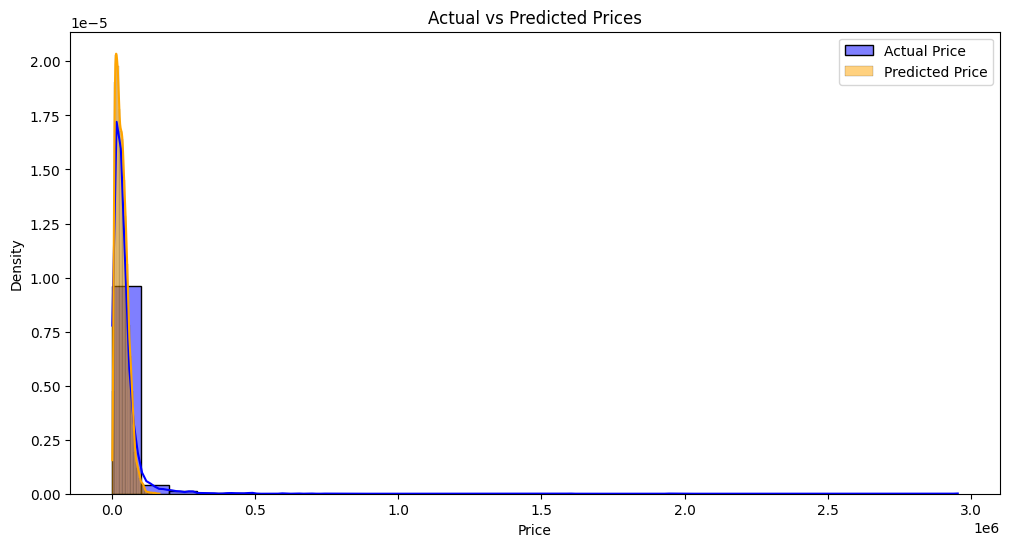

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제 가격과 예측된 가격 간의 비교 시각화
plt.figure(figsize=(12, 6))
sns.histplot(y_val_actual, color='blue', label='Actual Price', kde=True, stat='density', bins=30)
sns.histplot(predicted_price_log, color='orange', label='Predicted Price', kde=True, stat='density', bins=30)
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [46]:
import xgboost as xgb
### xgboost

# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# XGBoost 모델에 대한 GridSearchCV 설정
xgb_pipeline = Pipeline([('model', xgb.XGBRegressor(objective='reg:squarederror'))])

xgb_param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기 (cv=3)
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# XGBoost 모델 훈련
xgb_grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 RMSE 계산
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best XGBoost Parameters: {xgb_grid_search.best_params_}")

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred_xgb = best_xgb_model.predict(X_val)
rmse_xgb = rmse_scorer(y_val, y_val_pred_xgb)
print(f"XGBoost Validation RMSE: {rmse_xgb}")

# 테스트 데이터에 대한 예측
predicted_log_price_xgb = best_xgb_model.predict(test_final)
predicted_price_xgb = np.exp(predicted_log_price_xgb) #로그역변환


# 결과 출력
predicted_prices_df_xgb = pd.DataFrame({'predicted_price_xgb': predicted_price_xgb})
print(predicted_prices_df_xgb.head())

Best XGBoost Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__subsample': 1.0}
XGBoost Validation RMSE: 0.4888432249672083
   predicted_price_xgb
0         15743.841797
1         62645.316406
2         55098.335938
3         25272.453125
4         29832.972656


In [52]:
sub.price = predicted_prices_df_xgb.predicted_price_xgb

sub.to_csv('sub2_2.csv', index=False)

In [57]:
import xgboost as xgb
### xgboost

# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# XGBoost 모델에 대한 GridSearchCV 설정
xgb_pipeline = Pipeline([('model', xgb.XGBRegressor(objective='reg:squarederror'))])

xgb_param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기 (cv=3)
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)

# XGBoost 모델 훈련
xgb_grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 RMSE 계산
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best XGBoost Parameters: {xgb_grid_search.best_params_}")

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred_xgb = best_xgb_model.predict(X_val)
rmse_xgb = rmse_scorer(y_val, y_val_pred_xgb)
print(f"XGBoost Validation RMSE: {rmse_xgb}")

# 테스트 데이터에 대한 예측
predicted_log_price_xgb = best_xgb_model.predict(test_final)
predicted_price_xgb = np.exp(predicted_log_price_xgb) #로그역변환


# 결과 출력
predicted_prices_df_xgb = pd.DataFrame({'predicted_price_xgb': predicted_price_xgb})
print(predicted_prices_df_xgb.head())

Best XGBoost Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__subsample': 1.0}
XGBoost Validation RMSE: 0.4888432249672083
   predicted_price_xgb
0         15743.841797
1         62645.316406
2         55098.335938
3         25272.453125
4         29832.972656


In [49]:
import lightgbm as lgb


## LightGBM


# train_final에서 feature와 target 분리
X = train_final.drop(columns=['price', 'log_price'])  # log_price와 price 제거
y = train_final['log_price']  # 로그 변환된 가격 사용

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# LightGBM 모델에 대한 파이프라인 설정
lgb_pipeline = Pipeline([('model', lgb.LGBMRegressor())])

# 하이퍼파라미터 설정
lgb_param_grid = {
    'model__max_depth': [-1, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
lgb_grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 RMSE 계산
best_lgb_model = lgb_grid_search.best_estimator_
print(f"Best LightGBM Parameters: {lgb_grid_search.best_params_}")

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred_lgb = best_lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print(f"LightGBM Validation RMSE: {rmse_lgb}")

# 테스트 데이터에 대한 예측
predicted_log_price_lgb = best_lgb_model.predict(test_final)
predicted_price_lgb = np.exp(predicted_log_price_lgb)  # 로그 역변환

# 결과 출력
predicted_prices_df_lgb = pd.DataFrame({'predicted_price_lgb': predicted_price_lgb})
print(predicted_prices_df_lgb.head())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 145992, number of used features: 20
[LightGBM] [Info] Start training from score 10.283078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

<AxesSubplot: >

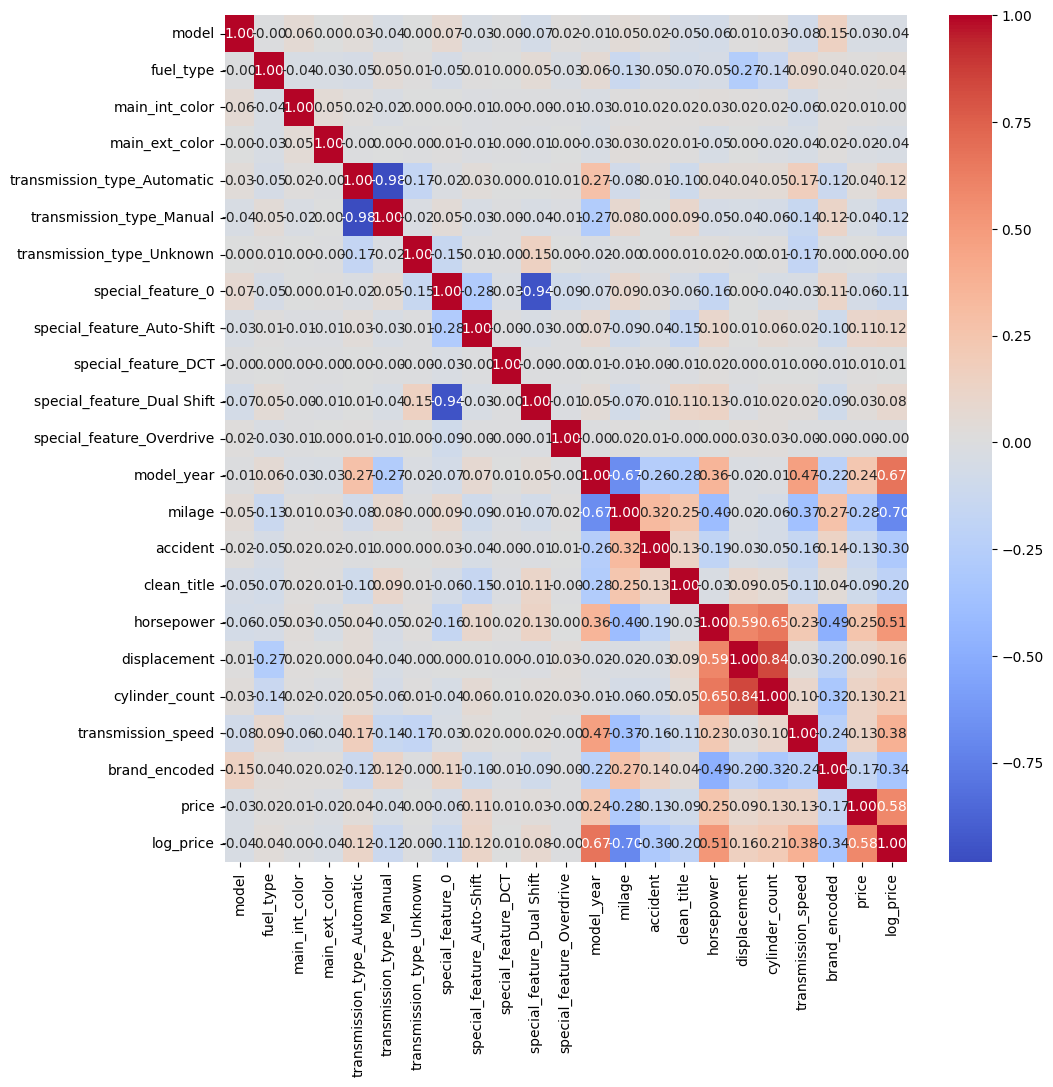

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,11))

corr_matrix = train_final.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')



<AxesSubplot: >

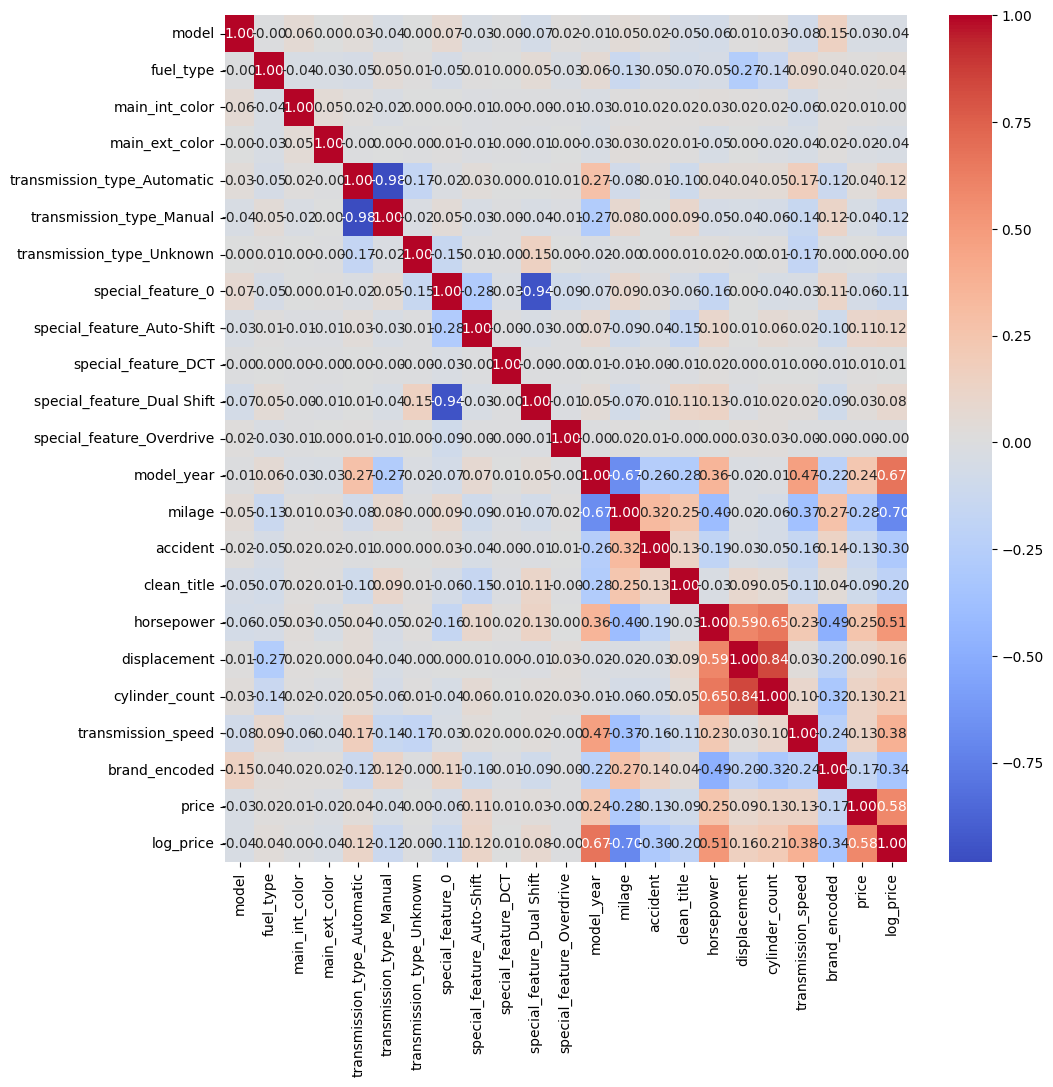

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,11))

corr_matrix = train_final.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

In [13]:
train.brand.unique()

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Cadillac', 'Land', 'GMC', 'Toyota', 'Hyundai',
       'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM', 'Hummer', 'Alfa',
       'INFINITI', 'Tesla', 'Jeep', 'Porsche', 'McLaren', 'Honda',
       'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia', 'Mitsubishi',
       'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn', 'Bentley', 'Mazda',
       'Subaru', 'Ferrari', 'Aston', 'Lamborghini', 'Chrysler', 'Lucid',
       'Lotus', 'Scion', 'smart', 'Karma', 'Plymouth', 'Suzuki', 'FIAT',
       'Saab', 'Mercury', 'Polestar', 'Maybach'], dtype=object)

In [18]:
train.groupby('model')['price'].mean().sort_values(ascending=False)

model
Carrera GT Base                    356937.250000
Gallardo SE                        265551.272727
Phantom Drophead Coupe Drophead    263600.625000
Continental GT GT Speed            244661.833333
Martin DB7 Vantage Volante         229714.312500
                                       ...      
E-Class D 2.5 Turbo                  8237.500000
Yaris L                              8215.625000
Matrix XR                            7742.181818
Integra LS                           7683.117647
Protege DX                           6749.800000
Name: price, Length: 1851, dtype: float64

In [20]:
train[train['model']=='Protege DX']

,brand,model,model_year,milage,fuel_type,accident,clean_title,price,horsepower,displacement,cylinder_count,log_price,transmission_type,transmission_speed,special_feature,main_int_color,main_ext_color
48716,Mazda,Protege DX,1993,174000,Gasoline,0,1,6750.0,140.0,1.8,4.0,8.817446,Manual,5,0,Black,White
56181,Mazda,Protege DX,2005,130000,Gasoline,0,1,8000.0,150.0,2.4,4.0,8.987322,Manual,5,0,Black,Silver
62481,Mazda,Protege DX,1994,170000,Gasoline,1,1,9000.0,140.0,1.8,4.0,9.105091,Automatic,0,0,Beige,Green
78161,Mazda,Protege DX,1993,95200,Gasoline,1,1,3499.0,140.0,1.8,4.0,8.160518,Automatic,5,0,Beige,Blue
83759,Mazda,Protege DX,2000,118500,Gasoline,0,1,6500.0,140.0,1.8,4.0,8.779711,Automatic,4,0,NN,Silver


In [47]:
import lightgbm as lgb


## LightGBM


# train_final에서 feature와 target 분리
X = train_final.drop(columns=['price', 'log_price'])  # log_price와 price 제거
y = train_final['log_price']  # 로그 변환된 가격 사용

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# LightGBM 모델에 대한 파이프라인 설정
lgb_pipeline = Pipeline([('model', lgb.LGBMRegressor())])

# 하이퍼파라미터 설정
lgb_param_grid = {
    'model__max_depth': [-1, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [200, 500, 700],
    'model__subsample': [0.8, 0.9],
    'model__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
lgb_grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 RMSE 계산
best_lgb_model = lgb_grid_search.best_estimator_
print(f"Best LightGBM Parameters: {lgb_grid_search.best_params_}")

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred_lgb = best_lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print(f"LightGBM Validation RMSE: {rmse_lgb}")

# 테스트 데이터에 대한 예측
predicted_log_price_lgb = best_lgb_model.predict(test_final)
predicted_price_lgb = np.exp(predicted_log_price_lgb)  # 로그 역변환

# 결과 출력
predicted_prices_df_lgb = pd.DataFrame({'predicted_price_lgb': predicted_price_lgb})
print(predicted_prices_df_lgb.head())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 145992, number of used features: 18
[LightGBM] [Info] Start training from score 10.283078
Best LightGBM Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 500, 'model__subsample': 0.8}
LightGBM Validation RMSE: 0.48974079433894707
   predicted_price_lgb
0         16021.614560
1         61745.067568
2         52045.046189
3         23763.759040
4         29491.419098


In [58]:
rmse_lgb #2 rmse

0.4892996572151656

In [54]:
rmse_lgb #1 mse

0.4892996572151656

In [48]:
sub.price = predicted_prices_df_lgb.predicted_price_lgb

sub.to_csv('sub3_1.csv', index=False)

In [50]:
predicted_prices_df_lgb

,predicted_price_lgb
0,16043.708886
1,59231.865063
2,52921.143722
3,24756.277554
4,30209.371918
...,...
125685,23932.685527
125686,42802.007533
125687,19170.106035
125688,13151.495716


In [ ]:
X = train_final.drop(columns=['price', 'log_price'])  # 특성 (price와 log_price 제외)
y = train['log_price']  # 타겟 변수 (log_price)

# 데이터 분할 (훈련/검증)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_final)

# PyTorch 데이터셋 클래스 정의
class CarPriceDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.FloatTensor(self.features[index]), torch.FloatTensor([self.targets[index]])

# 데이터 로더 설정
train_dataset = CarPriceDataset(X_train, y_train.values)
val_dataset = CarPriceDataset(X_val, y_val.values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 모델, 손실 함수 및 옵티마이저 설정
model = NeuralNetwork(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features).squeeze()
        loss = criterion(outputs, batch_targets.squeeze())
        loss.backward()
        optimizer.step()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_features, val_targets in val_loader:
            val_outputs = model(val_features).squeeze()
            val_loss += criterion(val_outputs, val_targets.squeeze()).item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

# 테스트 데이터 예측
model.eval()
with torch.no_grad():
    test_predictions = model(torch.FloatTensor(X_test)).squeeze().numpy()

# 로그 변환된 가격을 역변환
test_predictions_exp = np.exp(test_predictions)

# 예측 결과 출력
submission = pd.DataFrame({'id': test['id'], 'price': test_predictions_exp})
submission.to_csv('submission.csv', index=False)

In [75]:
pip install pytorch-tabnet

   ---------------------------------------- 0.0/44.5 kB ? eta -:--:--
   ---------------------------------------- 44.5/44.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.6/199.4 MB 13.3 MB/s eta 0:00:15
   ---------------------------------------- 1.0/199.4 MB 10.1 MB/s eta 0:00:20
   ---------------------------------------- 1.4/199.4 MB 10.2 MB/s eta 0:00:20
   ---------------------------------------- 1.8/199.4 MB 9.6 MB/s eta 0:00:21
   ---------------------------------------- 2.3/199.4 MB 10.3 MB/s eta 0:00:20
    --------------------------------------- 2.8/199.4 MB 10.5 MB/s eta 0:00:19
    --------------------------------------- 3.6/199.4 MB 10.9 MB/s eta 0:00:18
    --------------------------------------- 4.3/199.4 MB 11.0 MB/s eta 0:00:18
    --------------------------------------- 4.8/199.4 MB 11.0 MB/s eta 0:00:18
   - -------------------------------------- 5.4/199.4 MB 11.1 MB/s eta 0:00:18

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.2.0 requires scikit-learn<1.3.0,>=1.0, but you have scikit-learn 1.3.2 which is incompatible.


In [78]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
# TabNet 모델 생성 및 학습
tabnet_model = TabNetRegressor()
tabnet_model.fit(X_train.values, y_train.values.reshape(-1, 1),  # 2D로 변환
                 eval_set=[(X_val.values, y_val.values.reshape(-1, 1))],  # 2D로 변환
                 eval_metric=['rmse'], 
                 max_epochs=100)

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred_tabnet = tabnet_model.predict(X_val.values)
rmse_tabnet = np.sqrt(mean_squared_error(y_val, y_val_pred_tabnet))
print(f"TabNet Validation RMSE: {rmse_tabnet}")

# 테스트 데이터에 대한 예측
predicted_log_price_tabnet = tabnet_model.predict(test_final.values)
predicted_price_tabnet = np.exp(predicted_log_price_tabnet)

# 결과 출력
predicted_prices_df_tabnet = pd.DataFrame({'predicted_price_tabnet': predicted_price_tabnet})
print(predicted_prices_df_tabnet.head())

c:\Users\mm\anaconda3\envs\flood\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 12.36057| val_0_rmse: 1.05751 |  0:00:08s
epoch 1  | loss: 0.32675 | val_0_rmse: 1.61129 |  0:00:17s
epoch 2  | loss: 0.30075 | val_0_rmse: 0.90762 |  0:00:26s
epoch 3  | loss: 0.28588 | val_0_rmse: 0.61183 |  0:00:35s
epoch 4  | loss: 0.28122 | val_0_rmse: 0.52428 |  0:00:43s
epoch 5  | loss: 0.27897 | val_0_rmse: 0.51634 |  0:00:51s
epoch 6  | loss: 0.27744 | val_0_rmse: 0.5184  |  0:01:00s
epoch 7  | loss: 0.27255 | val_0_rmse: 0.51382 |  0:01:09s
epoch 8  | loss: 0.26948 | val_0_rmse: 0.511   |  0:01:17s
epoch 9  | loss: 0.26972 | val_0_rmse: 0.51013 |  0:01:26s
epoch 10 | loss: 0.26733 | val_0_rmse: 0.50896 |  0:01:34s
epoch 11 | loss: 0.26789 | val_0_rmse: 0.5136  |  0:01:42s
epoch 12 | loss: 0.2653  | val_0_rmse: 0.50848 |  0:01:50s
epoch 13 | loss: 0.26561 | val_0_rmse: 0.53646 |  0:01:58s
epoch 14 | loss: 0.26818 | val_0_rmse: 0.52406 |  0:02:06s
epoch 15 | loss: 0.26518 | val_0_rmse: 0.51528 |  0:02:14s
epoch 16 | loss: 0.26679 | val_0_rmse: 0.50732 |  0:02:2

c:\Users\mm\anaconda3\envs\flood\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Validation RMSE: 0.5027577051001907


ValueError: Per-column arrays must each be 1-dimensional

In [79]:
# 테스트 데이터에 대한 예측
predicted_log_price_tabnet = tabnet_model.predict(test_final.values)
predicted_price_tabnet = np.exp(predicted_log_price_tabnet)

# 결과를 DataFrame으로 변환 (1D 배열로 변환)
predicted_prices_df_tabnet = pd.DataFrame({'predicted_price_tabnet': predicted_price_tabnet.flatten()})  # flatten() 사용
print(predicted_prices_df_tabnet.head())

   predicted_price_tabnet
0            16413.589844
1            64468.601562
2            51276.695312
3            22209.619141
4            27736.302734


In [80]:
# 결과를 DataFrame으로 변환 (1D 배열로 변환)
predicted_prices_df_tabnet = pd.DataFrame({'predicted_price_tabnet': predicted_price_tabnet.reshape(-1)})  # reshape 사용
print(predicted_prices_df_tabnet.head())

   predicted_price_tabnet
0            16413.589844
1            64468.601562
2            51276.695312
3            22209.619141
4            27736.302734


In [81]:
sub.price = predicted_prices_df_tabnet.predicted_price_tabnet

sub.to_csv('sub2_5.csv', index=False)

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 분할
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# 데이터 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 모델 정의
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # 회귀 문제이므로 출력층은 하나
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val))

# 예측
y_val_pred = model.predict(X_val_scaled)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price = np.exp(y_val_pred)  # 로그 변환된 예측값을 원래 가격으로 변환

Epoch 1/100
4563/4563 [==============================] - 3s 666us/step - loss: 1.2032 - val_loss: 0.2896
Epoch 2/100
4563/4563 [==============================] - 3s 642us/step - loss: 0.2841 - val_loss: 0.2746
Epoch 3/100
4563/4563 [==============================] - 3s 611us/step - loss: 0.2788 - val_loss: 0.2657
Epoch 4/100
4563/4563 [==============================] - 3s 621us/step - loss: 0.2742 - val_loss: 0.2616
Epoch 5/100
4563/4563 [==============================] - 3s 605us/step - loss: 0.2718 - val_loss: 0.2625
Epoch 6/100
4563/4563 [==============================] - 3s 613us/step - loss: 0.2701 - val_loss: 0.2671
Epoch 7/100
4563/4563 [==============================] - 3s 623us/step - loss: 0.2692 - val_loss: 0.2567
Epoch 8/100
4563/4563 [==============================] - 3s 609us/step - loss: 0.2672 - val_loss: 0.2681
Epoch 9/100
4563/4563 [==============================] - 3s 617us/step - loss: 0.2669 - val_loss: 0.2570
Epoch 10/100
4563/4563 [==============================]

In [67]:
# 훈련 데이터에 대한 예측
y_train_pred = model.predict(X_train_scaled)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price_train = np.exp(y_train_pred)

# RMSE 계산
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train RMSE: {rmse_train}')

Train RMSE: 0.49410495815270006


In [63]:
# 테스트 데이터 스케일링
X_test_scaled = scaler.transform(test_final)  # test_final은 test 데이터셋

# 예측
y_test_pred = model.predict(X_test_scaled)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price_test = np.exp(y_test_pred)

# 결과를 DataFrame으로 변환 (필요한 경우)
results = pd.DataFrame({'predicted_price': predicted_price_test.flatten()})

# 결과 출력
print(results)

        predicted_price
0          16493.253906
1          67133.343750
2          52845.093750
3          22448.820312
4          27876.050781
...                 ...
125685     22266.349609
125686     41669.058594
125687     20242.347656
125688     14062.227539
125689     33306.421875

[125690 rows x 1 columns]


In [70]:
results

,predicted_price
0,16493.253906
1,67133.343750
2,52845.093750
3,22448.820312
4,27876.050781
...,...
125685,22266.349609
125686,41669.058594
125687,20242.347656
125688,14062.227539


In [68]:
sub.price = results.predicted_price

sub.to_csv('sub2_4.csv', index=False)

In [62]:
predicted_price

array([[40733.89 ],
       [31360.514],
       [44941.49 ],
       ...,
       [16191.823],
       [80875.086],
       [57394.215]], dtype=float32)

In [73]:
import autokeras as ak

# 데이터 준비
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# AutoKeras 모델 정의
model = ak.AutoModel(
    inputs=ak.Input(shape=(X.shape[1],)),  # 입력 형태
    outputs=ak.RegressionHead(),  # 회귀 문제
    overwrite=True,
    max_trials=10  # 최대 시도 횟수
)

# 모델 훈련
model.fit(X, y, epochs=100)

# 테스트 데이터에 대한 예측
predicted_price_test = model.predict(test_final)
predicted_price_test = np.exp(predicted_price_test) 

ModuleNotFoundError: No module named 'autokeras'

In [72]:
pip install autokeras

INFO: pip is looking at multiple versions of autokeras to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guida

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\Users\\mm\\anaconda3\\envs\\flood\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# AutoModel 정의
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # 회귀 문제의 경우 출력층은 하나
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 예측
predictions = model.predict(X_test)

NameError: name 'input_shape' is not defined

In [55]:
# 릿지 회귀

from sklearn.linear_model import Ridge


# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# 파이프라인 생성
pipeline = Pipeline([('model', Ridge())])

# 하이퍼파라미터 설정
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]  # 정규화 강도를 조절하는 alpha 값 튜닝
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Validation 데이터셋에 대해 예측 및 평가
y_val_pred = best_model.predict(X_val)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {rmse}")

# test_final의 log_price 예측
predicted_log_price = best_model.predict(test_final)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price = np.exp(predicted_log_price)

# 결과 확인
predicted_prices_df = pd.DataFrame({'predicted_price': predicted_price})

print(predicted_prices_df.head())

Best Parameters: {'model__alpha': 100}
Validation RMSE: 0.5231573310783553
   predicted_price
0     18434.954021
1     54618.584785
2     55526.781404
3     24669.411427
4     27562.410586


In [ ]:
neg_root_mean_squared_error

In [12]:
best_model

Pipeline(steps=[('model', Ridge(alpha=100))])

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['log_price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# 두 가지 파이프라인 생성 (StandardScaler와 MinMaxScaler 각각 사용)
pipelines = {
    'standard_scaler': Pipeline([
        ('scaler', StandardScaler()),  # StandardScaler 적용
        ('model', LinearRegression())
    ]),
    'minmax_scaler': Pipeline([
        ('scaler', MinMaxScaler()),  # MinMaxScaler 적용
        ('model', LinearRegression())
    ])
}

# 두 가지 스케일링 방법에 따른 결과 저장
results = {}

for name, pipeline in pipelines.items():
    # 모델 훈련
    pipeline.fit(X_train, y_train)
    
    # 검증 데이터셋에 대해 예측
    y_val_pred = pipeline.predict(X_val)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results[name] = rmse

# 결과 출력
for name, rmse in results.items():
    print(f"{name} RMSE: {rmse}")

# test_final의 log_price 예측 (StandardScaler 사용)
predicted_log_price_standard = pipelines['standard_scaler'].predict(test_final)
predicted_price_standard = np.exp(predicted_log_price_standard)

# test_final의 log_price 예측 (MinMaxScaler 사용)
predicted_log_price_minmax = pipelines['minmax_scaler'].predict(test_final)
predicted_price_minmax = np.exp(predicted_log_price_minmax)

# 결과 확인
predicted_prices_standard_df = pd.DataFrame({'predicted_price_standard': predicted_price_standard})
predicted_prices_minmax_df = pd.DataFrame({'predicted_price_minmax': predicted_price_minmax})

print(predicted_prices_standard_df.head())
print(predicted_prices_minmax_df.head())

standard_scaler RMSE: 0.5231656354709565
minmax_scaler RMSE: 0.5231494617971252
   predicted_price_standard
0              18448.070538
1              54667.670190
2              55518.395732
3              24656.837984
4              27558.092498
   predicted_price_minmax
0            18439.781080
1            54649.284781
2            55496.335228
3            24644.392961
4            27539.831995


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# train_final에서 feature와 target 분리
X = train_final.drop(columns=['log_price', 'price'])
y = train_final['price']

# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

# 세 가지 파이프라인 생성 (스케일링 없이, StandardScaler, MinMaxScaler 각각 사용)
pipelines = {
    'no_scaler': Pipeline([  # 스케일링 없이 진행
        ('model', LinearRegression())
    ]),
    'standard_scaler': Pipeline([  # StandardScaler 사용
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'minmax_scaler': Pipeline([  # MinMaxScaler 사용
        ('scaler', MinMaxScaler()),
        ('model', LinearRegression())
    ])
}

# 세 가지 스케일링 방법에 따른 결과 저장
results = {}

for name, pipeline in pipelines.items():
    # 모델 훈련
    pipeline.fit(X_train, y_train)
    
    # 검증 데이터셋에 대해 예측
    y_val_pred = pipeline.predict(X_val)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    results[name] = rmse

# 세 가지 방법에 대한 결과 출력
for name, rmse in results.items():
    print(f"{name} RMSE: {rmse}")

no_scaler RMSE: 70988.41557881927
standard_scaler RMSE: 70989.24455796237
minmax_scaler RMSE: 70987.87249062571


In [11]:
sub.price = predicted_prices_df.predicted_price

sub.to_csv('sub2_1.csv', index=False)

In [45]:
# train 데이터를 train/validation으로 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 결정 트리 모델 훈련
model = DecisionTreeRegressor(random_state=42)  # random_state를 설정하여 결과 재현 가능
model.fit(X_train, y_train)

# test_final의 log_price 예측
predicted_log_price = model.predict(test_final)

# 로그 변환을 역변환하여 원래의 가격으로 변환
predicted_price = np.exp(predicted_log_price)

# 결과 확인
predicted_prices_df = pd.DataFrame({
    'predicted_price': predicted_price
})

print(predicted_prices_df.head())

   predicted_price
0          23751.0
1          65999.0
2          52001.0
3          26951.0
4          30501.0


In [46]:
sub.price = predicted_prices_df.predicted_price

sub.to_csv('sub2.csv', index=False)

In [48]:
sub

,id,price
0,188533,23751.0
1,188534,65999.0
2,188535,52001.0
3,188536,26951.0
4,188537,30501.0
...,...,...
125685,314218,13001.0
125686,314219,68000.0
125687,314220,25001.0
125688,314221,15001.0
